In this notebook, we will write a search algorithm to accomplish a common statistical learning task: **simple linear regression**. Although we can solve the simple linear regression task using Calculus, we will take a search-based approach. The following code block imports some libraries we will use.

In [1]:
import itertools
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf

sns.set_style('whitegrid')

The following code block generates sample data we will use to develop our approach.

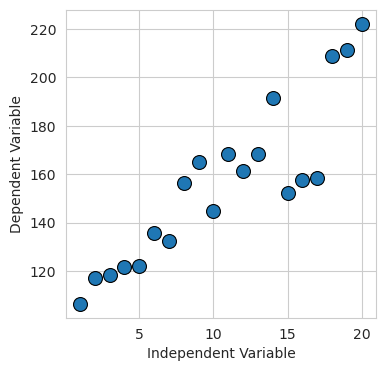

In [2]:
np.random.seed(0)
m = 5
b = 100

independent_variable = np.array([i for i in range(1, 21)])
signal = m*independent_variable + b
noise = np.random.uniform(
    low=0.85,
    high=1.15,
    size=len(independent_variable),
)
dependent_variable = signal*noise

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.scatterplot(
    x=independent_variable,
    y=dependent_variable,
    s=100,
    edgecolor='k',
)
ax.set_xlabel('Independent Variable')
ax.set_ylabel('Dependent Variable')

plt.show()

Note that two `numpy` arrays, `independent_variable` and `dependent_variable`, store our initial data

In [3]:
print(f'{independent_variable = }\n')
print(f'{dependent_variable = }')

independent_variable = array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

dependent_variable = array([106.53762537, 117.10124909, 118.54533647, 121.61579459,
       122.13705498, 135.68987041, 132.47228206, 156.45446603,
       165.16933008, 144.75486835, 168.56521427, 161.38695615,
       168.36820577, 191.70542855, 152.47939306, 157.70498218,
       158.37212106, 208.9593312 , 211.27216993, 222.20072889])


Before we discuss our search procedure, let's look at what happens with the Residual Sum of Squares Error (RSSE) as *m* and *b* vary near the known values for these settings.

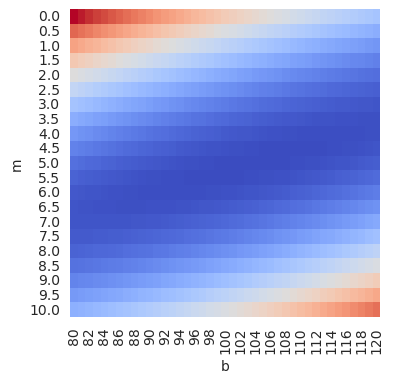

In [4]:
m_values = np.arange(0, 10.1, step=0.5).round(1)
b_values = np.arange(80, 121, step=1).round(0)

temp = pd.DataFrame(
    list(itertools.product(m_values, b_values)),
    columns=['m', 'b'],
)

temp['RSSE'] = temp.apply(
    lambda row: np.sum(np.power((row['m']*independent_variable + row['b']) - dependent_variable, 2)),
    axis=1,
)

temp = temp.pivot(
    index='m',
    columns='b',
    values='RSSE',
)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.heatmap(
    temp,
    cmap='coolwarm',
    cbar=False,
)
ax.set_xlabel('b')
ax.set_ylabel('m')

plt.show()

#### Procedure Pseudocode

- Specify `step_size`
- Specify `max_iterations`
- Initialize `m_best` and `b_best`
- Generate predictions based on `m_best` and `b_best`
- Compute Residual Sum of Squares Error (RSSE) for predictions and store as `best_error`
- Initialize `iteration = 0`
- Initialize `IMPROVING = True`
- **while** (`iteration < max_iterations`) and (`IMPROVING == True`):
  - `iteration += 1`
  - `IMPROVING = False`
  - Generate candidate values for *m* and *b* (`candidate_m` and `candidate_b`, resepctively)
  - Generate predictions based on `candidate_m` and `candidate_b`
  - Compute Residual Sum of Squares Error (RSSE) for predictions and store as `candidate_error`
  - **if** `candidate_error` < `best_error`:
    - `best_error` = `candidate_error`
    - `m_best` = `candidate_m`
    - `b_best` = `candidate_b`
    - `IMPROVING = True`
      
**return** `m_best`, `b_best`

#### Helper functions

After initializing the values for `m_best` and `b_best`, we need to compute the Residual Sum of Squares Error (RSSE). The first step of this process is to use the `m_best` and `b_best` values to generate predictions for each value of the independent variable. The following code block defines a function that does this.

In [5]:
def get_predictions(
    m_estimate: float,
    b_estimate: float,
    independent_variable_array: np.ndarray,
) -> np.ndarray:
    
    return m_estimate*independent_variable_array + b_estimate

The following code block demonstrates the use of the `get_predictions` function. The predictions are plotted with the generated data.

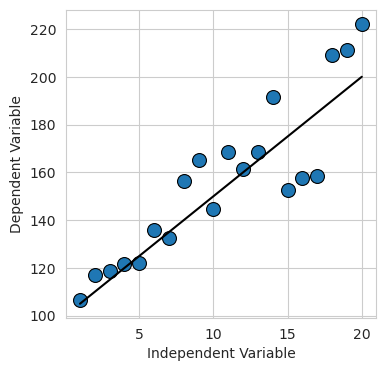

In [6]:
m_test = 5
b_test = 100

test_predictions = get_predictions(
    m_estimate=m_test,
    b_estimate=b_test,
    independent_variable_array=independent_variable,
)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

sns.scatterplot(
    x=independent_variable,
    y=dependent_variable,
    s=100,
    edgecolor='k',
)
ax.set_xlabel('Independent Variable')
ax.set_ylabel('Dependent Variable')

ax.plot(
    independent_variable,
    test_predictions,
    color='k',
)    

plt.show()

The following code block defines a function to compute the RSSE for a single array of prediction values.

In [7]:
def compute_RSSE(
    dependent_variable_array: np.ndarray,
    prediction_array: np.ndarray,
) -> float:

    RSSE_array = np.power(prediction_array - dependent_variable_array, 2)
    RSSE = RSSE_array.sum()

    return RSSE

The following code block demonstrates the use of the `compute_RSSE` function.

In [8]:
m_test = 5
b_test = 100

test_predictions = get_predictions(
    m_estimate=m_test,
    b_estimate=b_test,
    independent_variable_array=independent_variable,
)

test_RSSE = compute_RSSE(
    dependent_variable_array=dependent_variable,
    prediction_array=test_predictions,
)

When executing the search, we will generate candidate values for *m* and *b* by considering values that lie along a circle surrounding the current best values. The following code block generates two `numpy` arrays corresponding to the *x* and *y* coordinates for a circle with a specified radius and number of points. It is based on the trigonometric relationships: 
- $\sin(\theta) = \frac{\text{opposite}}{\text{hypotenuse}}$, and
- $\cos(\theta) = \frac{\text{adjacent}}{\text{hypotenuse}}$,</br>
where $\theta$ represents an angle in radians.

In [9]:
def generate_circle(
    radius: float = 1.0,
    points: int = 100,
) -> tuple:
    theta = np.linspace(0, 2*np.pi, points)
    x, y = radius * np.cos(theta), radius * np.sin(theta)

    return x, y

The following code demonstrates the correctness of the previous function.

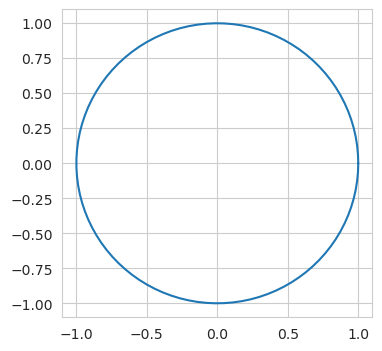

In [10]:
circle_x, circle_y = generate_circle(
    radius=1.0,
    points=100,
)

fig, ax = plt.subplots(1, 1, figsize=(4, 4))

ax.plot(
    circle_x,
    circle_y,
)

plt.show()

Instead of looping through all of the points on the circle when generating candidate values for *m* and *b*, we would like to compute all points in a vectorized manner. The following code block defines a function that uses `numpy` to execute these computations and return candidate *m* and *b* values that provide the lowest RSSE.

In [11]:
def get_best_move(
    starting_m: float,
    starting_b: float,
    independent_variable_array: np.ndarray,
    dependent_variable_array: np.ndarray,
    step_size: float = 1.0,
    step_samples: int = 100,
) -> tuple:

    circle_m, circle_b = generate_circle(
        radius=step_size,
        points=step_samples,
    )
    
    candidate_m_array = starting_m + circle_m
    candidate_b_array = starting_b + circle_b
    
    prediction_array = candidate_m_array.reshape(-1, 1) * independent_variable_array.reshape(1, -1)
    prediction_array = prediction_array + candidate_b_array.reshape(-1, 1)
    
    RSE_array = np.power(prediction_array - dependent_variable_array.reshape(1, -1), 2)
    RSSE_array = RSE_array.sum(axis=1)
    
    min_idx = np.argmin(RSSE_array)
    
    min_m = candidate_m_array[min_idx]
    min_b = candidate_b_array[min_idx]
    
    return min_m, min_b

The following code block demonstrates the use of the `get_best_move` function.

In [12]:
m_test = 4
b_test = 80

test_predictions = get_predictions(
    m_estimate=m_test,
    b_estimate=b_test,
    independent_variable_array=independent_variable,
)

test_RSSE = compute_RSSE(
    dependent_variable_array=dependent_variable,
    prediction_array=test_predictions,
)

print(f' - {m_test = }')
print(f' - {b_test = }')
print(f' - {test_RSSE = }')
print('-'*40)

candidate_m, candidate_b = get_best_move(
    starting_m=m_test,
    starting_b=b_test,
    independent_variable_array=independent_variable,
    dependent_variable_array=dependent_variable,
    step_size=1.0,
    step_samples=100,
)

candidate_predictions = get_predictions(
    m_estimate=candidate_m,
    b_estimate=candidate_b,
    independent_variable_array=independent_variable,
)

candidate_RSSE = compute_RSSE(
    dependent_variable_array=dependent_variable,
    prediction_array=candidate_predictions,
)

print(f' - {candidate_m = }')
print(f' - {candidate_b = }')
print(f' - {candidate_RSSE = }')
print('-'*40)

 - m_test = 4
 - b_test = 80
 - test_RSSE = 27961.40669591679
----------------------------------------
 - candidate_m = 4.997986676471885
 - candidate_b = 80.06342391965657
 - candidate_RSSE = 15138.691024356007
----------------------------------------


Before we implement the search procedure, let's get the `statsmodels` solution so that we have a benchmark.

In [13]:
df = pd.DataFrame({
    'independent_variable': independent_variable,
    'dependent_variable': dependent_variable,
})

ols_model = smf.ols(
    formula='dependent_variable ~ independent_variable',
    data=df,
)
res = ols_model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     dependent_variable   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     73.91
Date:                Fri, 19 Apr 2024   Prob (F-statistic):           8.67e-08
Time:                        07:55:11   Log-Likelihood:                -81.519
No. Observations:                  20   AIC:                             167.0
Df Residuals:                      18   BIC:                             169.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              103.4833      6.979     14.827      0.000      88.820     118.146
independent_variable     5.0087      0.583      8.597      0.000       3.785       6.233
==============================================================================
Omnibus:                        2.073   Durbin-Watson:                   1.517
Prob(Omnibus):                  0.355   Jarque-Bera (JB):                1.574
Skew:                          -0.664   Prob(JB):                        0.455
Kurtosis:                       2.647   Cond. No.                         25.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The following code block implements the search procedure.

In [14]:
step_size = 1
max_iterations = 1000
m_best = 0
b_best = 0

current_predictions = get_predictions(
    m_estimate=m_best,
    b_estimate=b_best,
    independent_variable_array=independent_variable,
)
current_error = compute_RSSE(
    dependent_variable_array=dependent_variable,
    prediction_array=current_predictions,
)
best_error = current_error

iteration = 0
IMPROVING = True
start_time = time.time()
iteration_details = [[iteration, m_best, b_best, best_error]]
while (iteration < max_iterations) and IMPROVING:
    iteration += 1
    IMPROVING = False

    candidate_m, candidate_b = get_best_move(
        starting_m=m_best,
        starting_b=b_best,
        independent_variable_array=independent_variable,
        dependent_variable_array=dependent_variable,
        step_size=step_size,
        step_samples=max_iterations,
    )
    
    candidate_predictions = get_predictions(
        m_estimate=candidate_m,
        b_estimate=candidate_b,
        independent_variable_array=independent_variable,
    )
    
    candidate_error = compute_RSSE(
        dependent_variable_array=dependent_variable,
        prediction_array=candidate_predictions,
    )
    if candidate_error < best_error:
        best_error = candidate_error
        m_best = candidate_m
        b_best = candidate_b
        IMPROVING = True
        iteration_details.append([iteration, m_best, b_best, best_error])

end_time = time.time()
elapsed_time = round(end_time - start_time, 5)

print(f'Step size: {step_size}')
print(f'Iterations: {iteration}')
print(f'Elapsed time: {elapsed_time} seconds')
print(f'm: {m_best}')
print(f'b: {b_best}')
print(f'mx + b -> {m_best}x + {b_best}')

Step size: 1
Iterations: 115
Elapsed time: 0.07966 seconds
m: 5.030936099809158
b: 103.15261151339963
mx + b -> 5.030936099809158x + 103.15261151339963


The following code block plots the progression of the search procedure over *m* and *b* values.

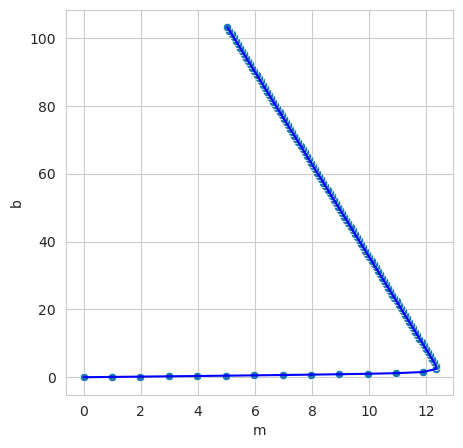

In [15]:
iteration_details = pd.DataFrame(
    iteration_details,
    columns=['iteration', 'm', 'b', 'RSSE'],
)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.scatterplot(
    data=iteration_details,
    x='m',
    y='b',
)

mb_values = iteration_details.values.tolist()
for idx, (iteration, m_hat, b_hat, RSSE) in enumerate(mb_values[1:], 1):
    ax.plot(
        [mb_values[idx-1][1], m_hat],
        [mb_values[idx-1][2], b_hat],
        color='blue',
    )

plt.show()

The following code block plots the line defined by the *m* and *b* values identified by the search procedure.

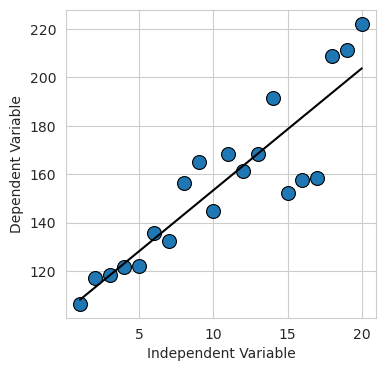

In [16]:
predictions = get_predictions(
    m_estimate=m_best,
    b_estimate=b_best,
    independent_variable_array=independent_variable,
)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))

sns.scatterplot(
    x=independent_variable,
    y=dependent_variable,
    s=100,
    edgecolor='k',
)
ax.set_xlabel('Independent Variable')
ax.set_ylabel('Dependent Variable')

ax.plot(
    independent_variable,
    predictions,
    color='k',
)

plt.show()

#### Things to think about
- What happens if we change the step size?
- What happens if we use a better starting point?